In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kurtosis, skew, norm
from tqdm import tqdm,trange

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
snp = pd.read_csv('SP500_DailyIndex-1.csv',index_col='Date', parse_dates=True)[['Adj Close']]
rf = pd.read_csv('FF3Factors_Daily.csv',index_col='Date', parse_dates=True)[['RF']]
rf = rf/100
rf

,RF
Date,
1926-07-01,0.00009
1926-07-02,0.00009
1926-07-06,0.00009
1926-07-07,0.00009
1926-07-08,0.00009
...,...
2017-12-22,0.00004
2017-12-26,0.00004
2017-12-27,0.00004


In [3]:
returns = snp.pct_change().dropna()
excess = returns.join(rf)
excess['excess'] = excess['Adj Close'] - excess.RF
excess.dropna(inplace=True)

excess

,Adj Close,RF,excess
Date,,,
1960-01-05,0.00801,0.00017,0.00784
1960-01-06,-0.00431,0.00017,-0.00448
1960-01-07,-0.00732,0.00017,-0.00749
1960-01-08,-0.00318,0.00017,-0.00335
1960-01-11,-0.01227,0.00017,-0.01244
...,...,...,...
2017-12-22,-0.00046,0.00004,-0.00050
2017-12-26,-0.00106,0.00004,-0.00110
2017-12-27,0.00079,0.00004,0.00075


In [4]:
m_excess = pd.DataFrame((excess.excess+1).resample('M').prod()-1)
m_excess.head()

,excess
Date,
1960-01-31,-0.07478
1960-02-29,0.00635
1960-03-31,-0.01730
1960-04-30,-0.01949
1960-05-31,0.02406


In [5]:
rolling_excess = pd.DataFrame((1+m_excess).rolling(12).apply(np.prod, raw=True) - 1)
rolling_excess.tail()

,excess
Date,
2017-08-31,0.13231
2017-09-30,0.15469
2017-10-31,0.20288
2017-11-30,0.19505
2017-12-31,0.18453


In [6]:
def calc_volatility(r_series):

    vol = pd.Series(np.zeros(len(r_series)))
    delta = 60.0 / 61.0
    d2 = 1 - delta

    for t in tqdm(range(len(r_series))):

        r = r_series.iloc[0:t+1]

        w = np.array(range(0,t+1))[::-1]
        
        deltas = d2 * (delta**w)

        exret_stdev = np.sqrt((261 * np.dot(deltas, ((r - np.dot(deltas, r)) ** 2))))

        vol[t] += exret_stdev
    vol.index = r_series.index
    return vol

In [7]:
ex_ante = calc_volatility(excess.excess)

ex_ante


100%|███████████████████████████████████████████████████████████████████████████| 14598/14598 [01:04<00:00, 225.37it/s]


Date
1960-01-05   0.01596
1960-01-06   0.01852
1960-01-07   0.02400
1960-01-08   0.02469
1960-01-11   0.03487
               ...  
2017-12-22   0.06446
2017-12-26   0.06406
2017-12-27   0.06354
2017-12-28   0.06304
2017-12-29   0.06376
Length: 14598, dtype: float64

In [8]:
ex_ante.index = excess.index
ex_ante

Date
1960-01-05   0.01596
1960-01-06   0.01852
1960-01-07   0.02400
1960-01-08   0.02469
1960-01-11   0.03487
               ...  
2017-12-22   0.06446
2017-12-26   0.06406
2017-12-27   0.06354
2017-12-28   0.06304
2017-12-29   0.06376
Length: 14598, dtype: float64

In [9]:
mex = ex_ante.groupby(pd.Grouper(freq="M")).last()
df = pd.DataFrame(mex).join(rolling_excess)
df.columns = ["exa", "excess"]
df = df.dropna()

df['mexcess'] = m_excess
df["pos"] = np.sign(df.excess)
df["size"] = 0.4 / df.exa

df

,exa,excess,mexcess,pos,size
Date,,,,,
1960-12-31,0.10279,-0.05522,0.04474,-1.00000,3.89151
1961-01-31,0.09791,0.08358,0.06115,1.00000,4.08520
1961-02-28,0.09385,0.10400,0.02531,1.00000,4.26191
1961-03-31,0.08958,0.14984,0.02351,1.00000,4.46547
1961-04-30,0.13664,0.17509,0.00204,1.00000,2.92735
...,...,...,...,...,...
2017-08-31,0.07921,0.13231,-0.00037,1.00000,5.04980
2017-09-30,0.07311,0.15469,0.01829,1.00000,5.47105
2017-10-31,0.06685,0.20288,0.02129,1.00000,5.98355


In [10]:
df['tsret'] = df['pos'].shift(1) * df['size'].shift(1) * df.mexcess 
df.head()


,exa,excess,mexcess,pos,size,tsret
Date,,,,,,
1960-12-31,0.10279,-0.05522,0.04474,-1.00000,3.89151,nan
1961-01-31,0.09791,0.08358,0.06115,1.00000,4.08520,-0.23798
1961-02-28,0.09385,0.10400,0.02531,1.00000,4.26191,0.10340
1961-03-31,0.08958,0.14984,0.02351,1.00000,4.46547,0.10020
1961-04-30,0.13664,0.17509,0.00204,1.00000,2.92735,0.00910


In [11]:
st = df.index.searchsorted(dt.datetime(1965, 1, 1))
en = df.index.searchsorted(dt.datetime(2017, 12, 31))

ts_ret = pd.DataFrame(df.tsret.iloc[st:en])

m = ts_ret.mean() * 12
printmd(f'**Annualized TS Ret Mean: {m[0]}**')
s = ts_ret.std() * np.sqrt(12)
printmd(f'**Annualized TS Ret Standard Deviation: {s[0]}**')
sr = m/s
printmd(f'**Sharpe Ratio: {sr[0]}**')
ts_ret

**Annualized TS Ret Mean: 0.1464882471721862**

**Annualized TS Ret Standard Deviation: 0.4162823801947687**

**Sharpe Ratio: 0.35189634282298426**

,tsret
Date,
1965-01-31,0.20885
1965-02-28,-0.03359
1965-03-31,-0.12113
1965-04-30,0.22505
1965-05-31,-0.08488
...,...
2017-07-31,0.09494
2017-08-31,-0.00207
2017-09-30,0.09234


In [12]:
momentum = pd.read_csv("FF3Factors_MOM_Monthly.csv", parse_dates=True, index_col="Date")/100
momentum.drop("RF", axis=1, inplace=True)
join = pd.DataFrame(df['tsret']).join(momentum).dropna()
join.columns = ["tsret", "MKTRF", "SMB", "HML", "MOM"]
join.head()

,tsret,MKTRF,SMB,HML,MOM
Date,,,,,
1961-01-31,-0.23798,0.06200,0.00650,0.03700,-0.03970
1961-02-28,0.10340,0.03570,0.03970,-0.00740,0.01030
1961-03-31,0.10020,0.02890,0.03230,-0.00770,0.04180
1961-04-30,0.00910,0.00290,0.00130,0.02050,0.03520
1961-05-31,0.05102,0.02400,0.01950,0.00480,-0.01500


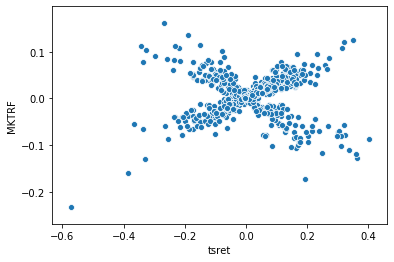

In [13]:
sns.scatterplot(x=join.tsret,y=join.MKTRF)

In [14]:
results = smf.ols('tsret ~ MKTRF', join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tsret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7922
Date:                Tue, 26 Nov 2019   Prob (F-statistic):              0.374
Time:                        19:19:02   Log-Likelihood:                 476.07
No. Observations:                 684   AIC:                            -948.1
Df Residuals:                     682   BIC:                            -939.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0115      0.005      2.471      0.014       0.002       0.021
MKTRF          0.0938      0.105      0.890      0.374      -0.113       0.301
==============================================================================
Omnibus:                       18.628   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.050
Skew:                          -0.122   Prob(JB):                     1.49e-08
Kurtosis:                       4.098   Cond. No.                         22.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
results2 = smf.ols('tsret ~ MKTRF + SMB + HML + MOM', join).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tsret   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     17.22
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           1.82e-13
Time:                        19:19:02   Log-Likelihood:                 508.73
No. Observations:                 684   AIC:                            -1007.
Df Residuals:                     679   BIC:                            -984.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0035      0.005      0.750      0.453      -0.006       0.013
MKTRF          0.3812      0.110      3.463      0.001       0.165       0.597
SMB           -0.4591      0.154     -2.983      0.003      -0.761      -0.157
HML            0.4926      0.171      2.884      0.004       0.157       0.828
MOM            0.8358      0.111      7.547      0.000       0.618       1.053
==============================================================================
Omnibus:                       20.992   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.906
Skew:                          -0.012   Prob(JB):                     3.96e-11
Kurtosis:                       4.296   Cond. No.                         40.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
ann_ts_ret = (ts_ret+1).resample('Y').prod()-1
ann_ts_ret.tail()


,tsret
Date,
2013-12-31,1.25447
2014-12-31,0.39847
2015-12-31,-0.31512
2016-12-31,0.11997
2017-12-31,1.14240


([], <a list of 0 Text xticklabel objects>)

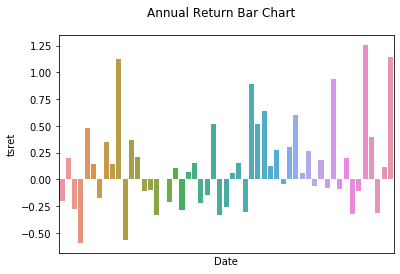

In [17]:
sns.barplot(ann_ts_ret.index,ann_ts_ret.tsret, data=ann_ts_ret)
plt.suptitle('Annual Return Bar Chart')
plt.xticks([])

In [18]:
std_error = (join.tsret - results.predict(join)).std()
info_ratio = results.params[0]/std_error
printmd(f'**The info ratio is: {info_ratio}**')

**The info ratio is: 0.09524849485015204**

Text(0.5, 0.98, 'Empirical Density Function')

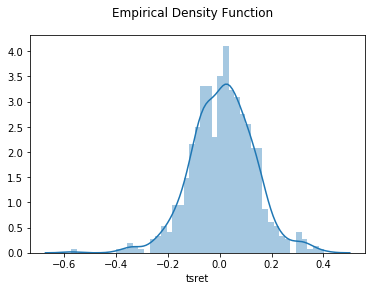

In [19]:
sns.distplot(join.tsret, bins=45)
plt.suptitle('Empirical Density Function')

In [20]:
hist_var = join.tsret.quantile(0.05)
printmd(f'**5% VAR: {hist_var}**')
printmd('**Kurtosis: {}**'.format( kurtosis(join.tsret) ))
printmd('**Skewness: {}**'.format( skew(join.tsret) ))

**5% VAR: -0.17388846608524994**

**Kurtosis: 1.1436305114347327**

**Skewness: -0.15938277432577416**

In [21]:
join.head()

,tsret,MKTRF,SMB,HML,MOM
Date,,,,,
1961-01-31,-0.23798,0.06200,0.00650,0.03700,-0.03970
1961-02-28,0.10340,0.03570,0.03970,-0.00740,0.01030
1961-03-31,0.10020,0.02890,0.03230,-0.00770,0.04180
1961-04-30,0.00910,0.00290,0.00130,0.02050,0.03520
1961-05-31,0.05102,0.02400,0.01950,0.00480,-0.01500


**The Max Draw Down is: -0.5623774965223647**

Text(0.5, 0.98, 'Draw Down from High Water Mark')

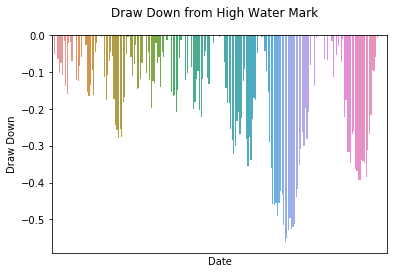

In [22]:

ddd = pd.DataFrame(ts_ret.tsret.loc['2000-01-01':'2017-11-30'])
ddd['cum_ret'] = (ddd +1).cumprod()
ddd['hwm'] = ddd.cum_ret.cummax()
ddd['dd'] = (ddd.cum_ret - ddd.hwm)/ddd.hwm

maxdd = min(ddd.dd)

printmd(f'**The Max Draw Down is: {maxdd}**')

sns.barplot(x = ddd.index, y = ddd.dd, data = ddd)
plt.ylabel('Draw Down')
plt.xticks([])
plt.suptitle('Draw Down from High Water Mark')
